# **Titanic Survival Prediction**

**Import Required Libraries**

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model Interpretability
import shap

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

**Load Datasets**

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

**Preview Data**

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


#### **Exploratory Data Analysis (EDA) & Feature Engineering**

In [7]:
# Total number of passengers
total_passengers = train_df.shape[0]
print(f"Total Passengers: {total_passengers}")

Total Passengers: 891


In [8]:
# Count of male and female passengers
gender_count = train_df['Sex'].value_counts().reset_index()
gender_count.columns = ['Gender', 'Count']
gender_count

,Gender,Count
0,male,577
1,female,314


In [9]:
# Count the number of people in each Pclass
pclass_count = train_df['Pclass'].value_counts().reset_index()
pclass_count.columns = ['Pclass', 'Count']  # Rename columns
pclass_count = pclass_count.sort_values(by='Pclass')  # Ensure sorted order
pclass_count

,Pclass,Count
1,1,216
2,2,184
0,3,491


**1. Survival Rate by Passenger Class (Pclass)**

In [10]:
pclass_survival = train_df.groupby(['Pclass'], as_index=False)['Survived'].mean()
pclass_survival

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


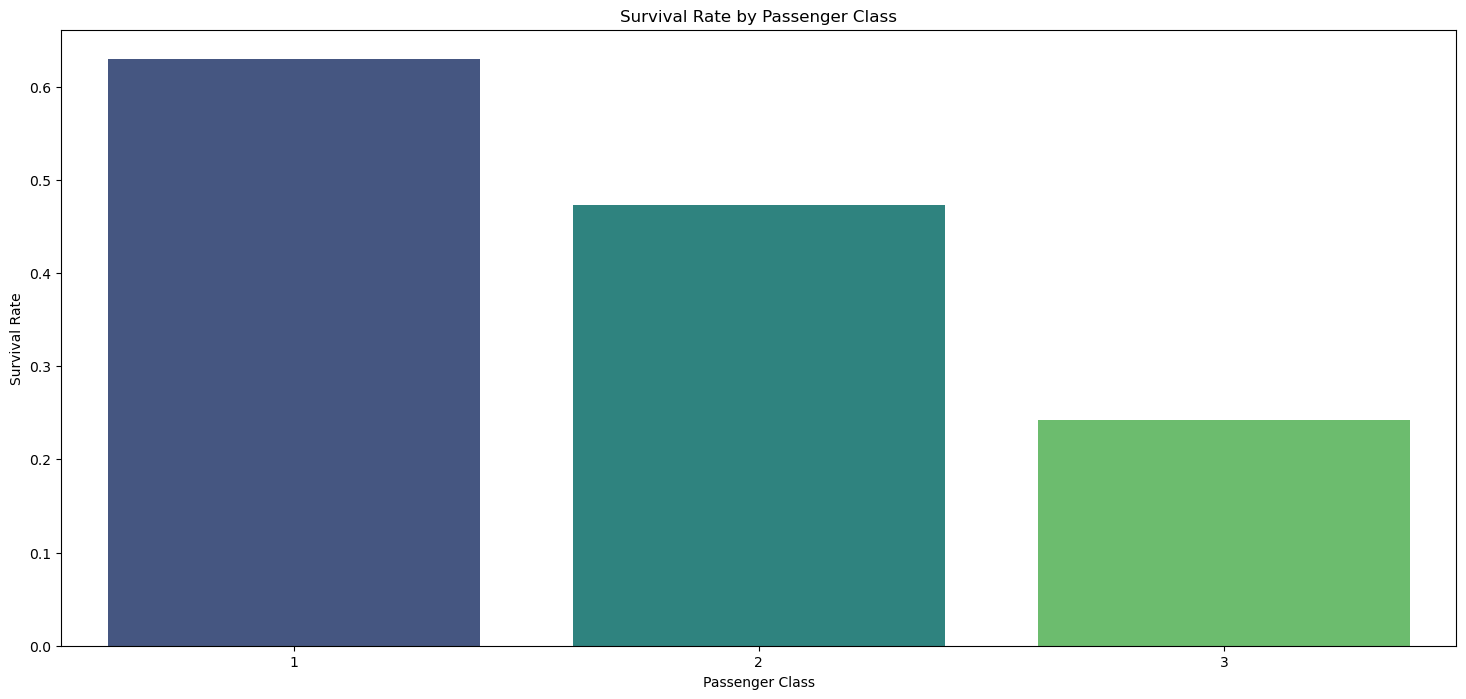

In [11]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Pclass', y='Survived', palette='viridis', data=pclass_survival)
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

**2. Survival Rate by Gender**

In [12]:
sex_survival = train_df.groupby(['Sex'], as_index=False)['Survived'].mean()
sex_survival

,Sex,Survived
0,female,0.742038
1,male,0.188908


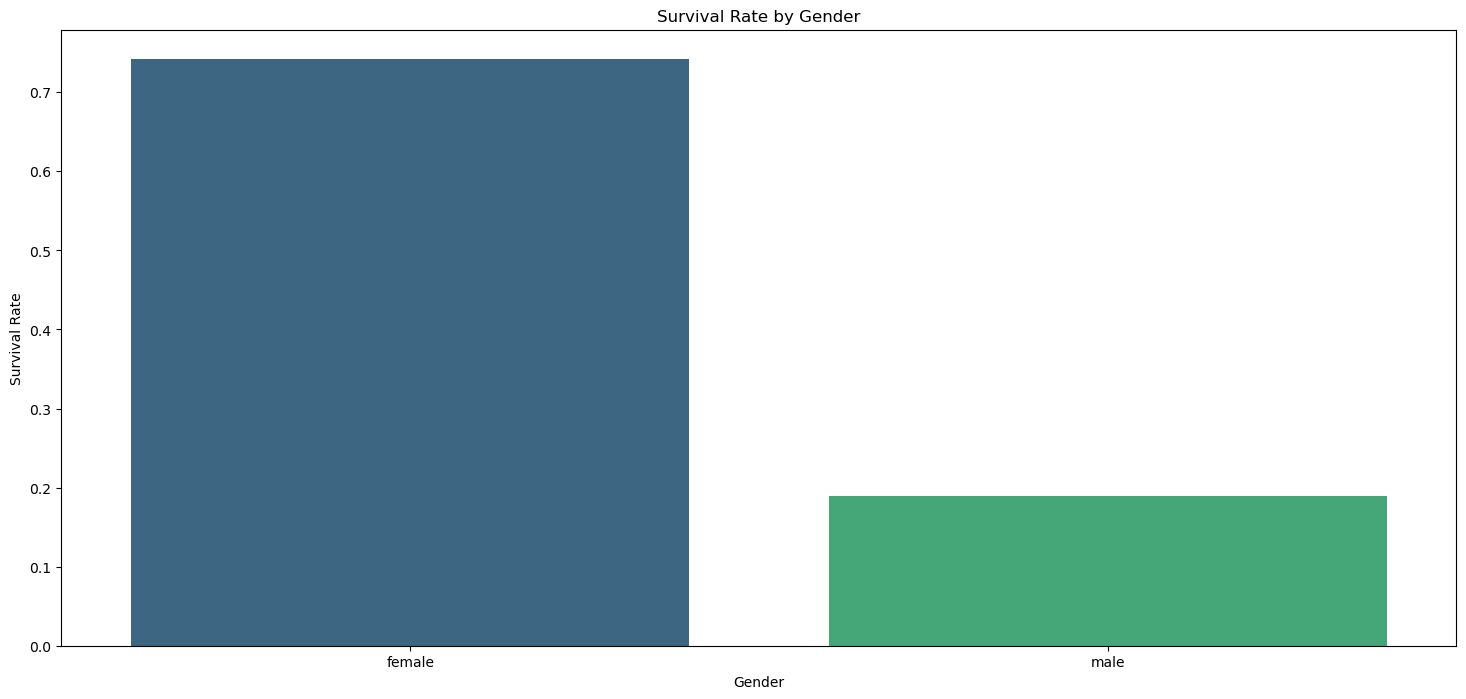

In [13]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Sex', y='Survived', palette='viridis', data=sex_survival)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.show()

**3. Survival Rate by Number of Siblings/Spouses (SibSp)**

In [14]:
sibsp_survival = train_df.groupby(['SibSp'], as_index=False)['Survived'].mean()
sibsp_survival

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


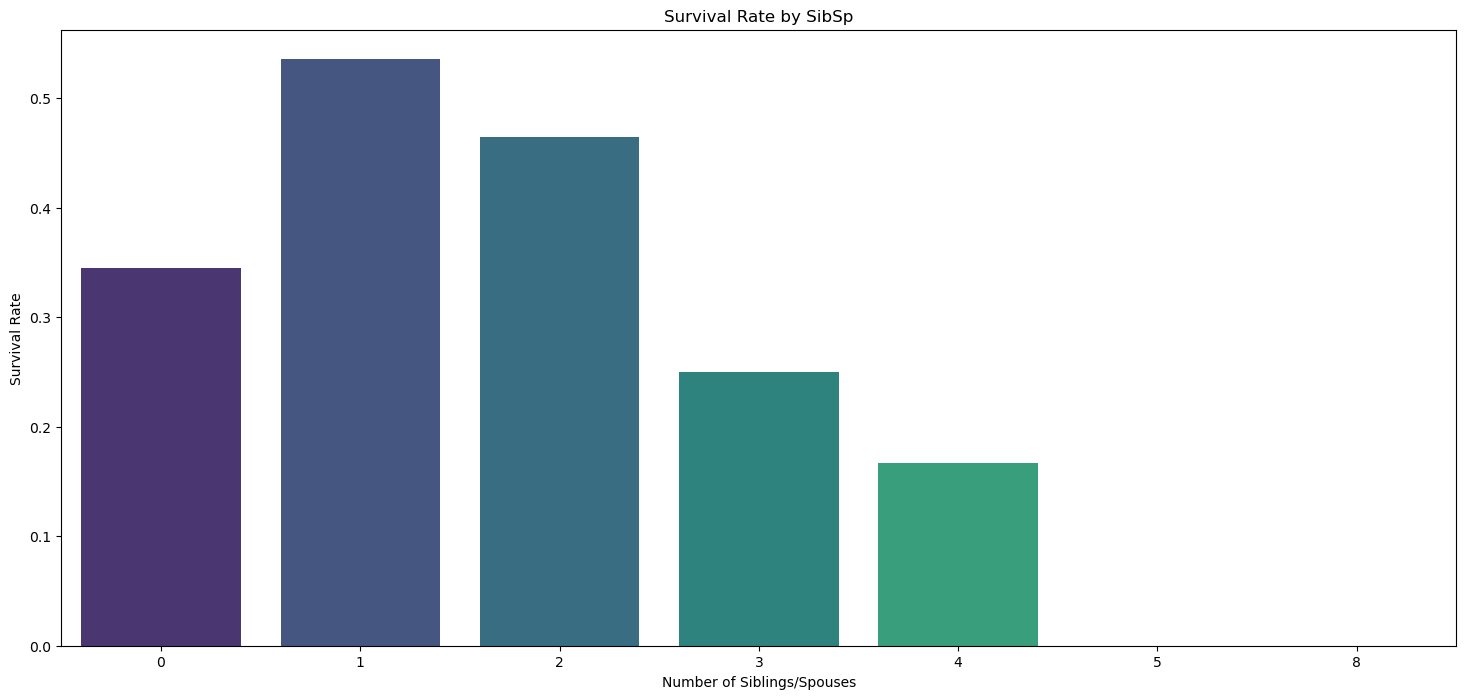

In [15]:
plt.figure(figsize=(18, 8))
sns.barplot(x='SibSp', y='Survived', palette='viridis', data=sibsp_survival)
plt.title('Survival Rate by SibSp')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Survival Rate')
plt.show()

**4. Survival Rate by Number of Parents/Children (Parch)**

In [16]:
parch_survival = train_df.groupby(['Parch'], as_index=False)['Survived'].mean()
parch_survival

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


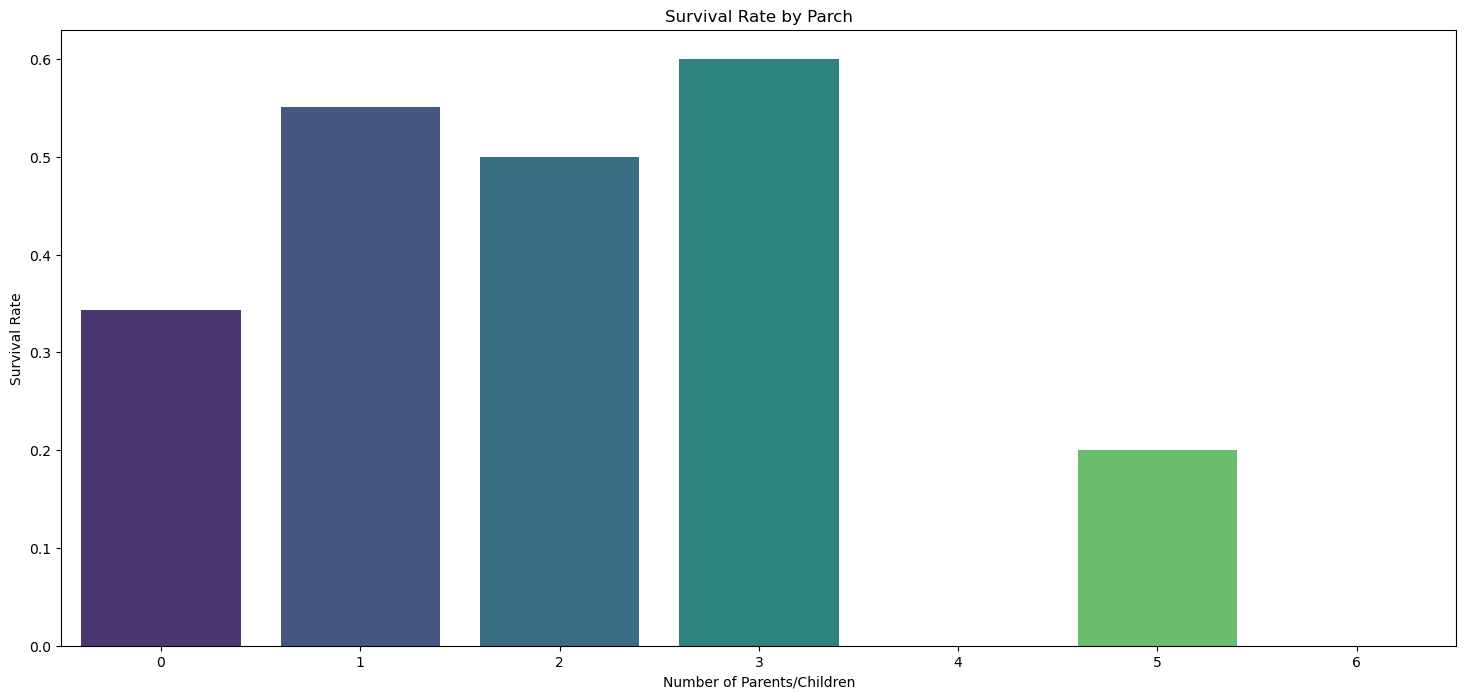

In [17]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Parch', y='Survived', palette='viridis' , data=parch_survival)
plt.title('Survival Rate by Parch')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Survival Rate')
plt.show()

**5. Survival Rate by Family Size**

In [18]:
# Create 'Family_Size' feature
train_df['Family_Size'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['Family_Size'] = test_df['SibSp'] + test_df['Parch'] + 1

In [19]:
family_size_survival = train_df.groupby(['Family_Size'], as_index=False)['Survived'].mean()
family_size_survival

,Family_Size,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


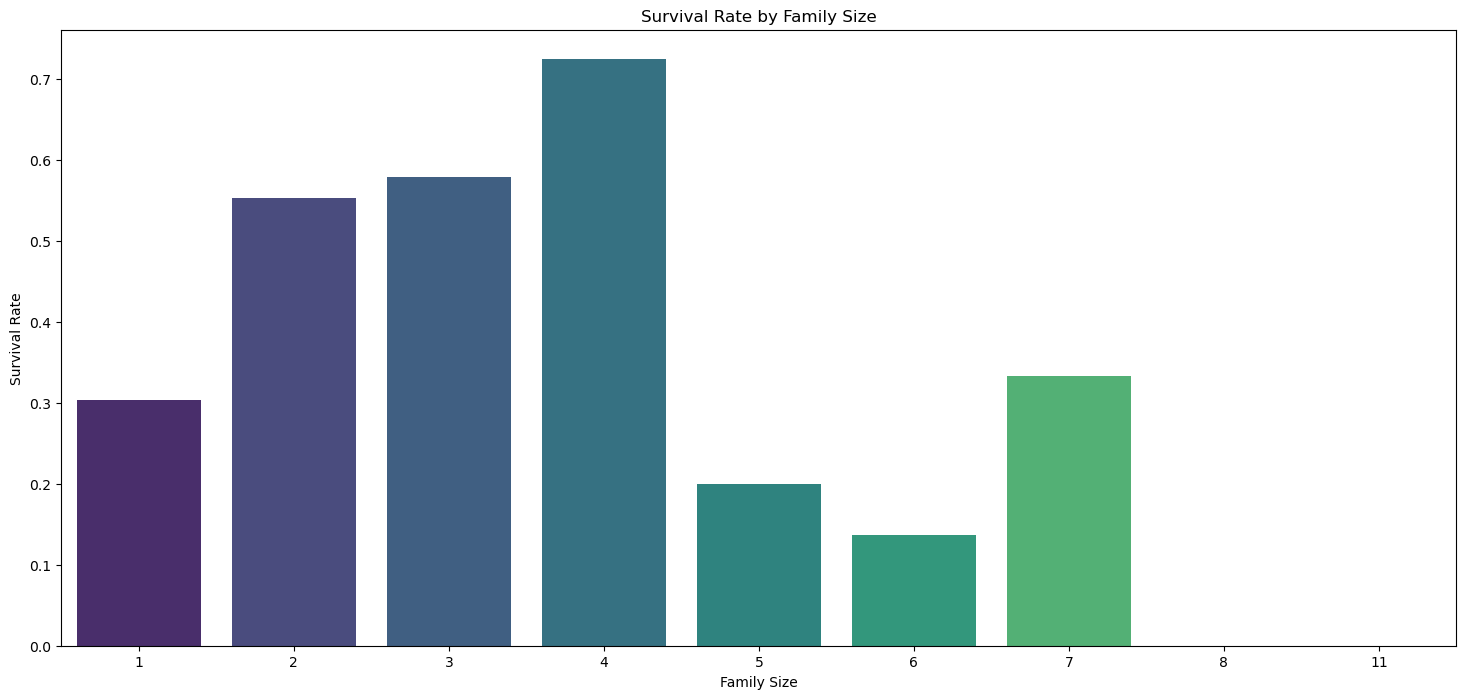

In [20]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Family_Size', y='Survived', palette='viridis', data=family_size_survival)
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size')
plt.ylabel('Survival Rate')
plt.show()

**6. Survival Rate by Family Size Grouped**

In [21]:
# Create 'IsAlone' feature
train_df['IsAlone'] = (train_df['Family_Size'] == 1).astype(int)
test_df['IsAlone'] = (test_df['Family_Size'] == 1).astype(int)
is_alone_survival_rates = train_df.groupby('IsAlone')['Survived'].mean().reset_index()
is_alone_survival_rates.rename(columns={'IsAlone': 'Alone', 'Survived': 'Survival Rate'}, inplace=True)
is_alone_survival_rates

,Alone,Survival Rate
0,0,0.505650
1,1,0.303538


In [22]:
# Define family size categories based on size
def categorize_family_size(size):
    if size == 1:
        return 'Alone'
    elif 2 <= size <= 4:
        return 'Small'
    elif 5 <= size <= 6:
        return 'Medium'
    else:
        return 'Large'

# Apply the categorization to both datasets
train_df['Family_Size_Grouped'] = train_df['Family_Size'].apply(categorize_family_size)
test_df['Family_Size_Grouped'] = test_df['Family_Size'].apply(categorize_family_size)

In [23]:
family_grouped_survival = train_df.groupby(['Family_Size_Grouped'], as_index=False)['Survived'].mean()
family_grouped_survival

,Family_Size_Grouped,Survived
0,Alone,0.303538
1,Large,0.160000
2,Medium,0.162162
3,Small,0.578767


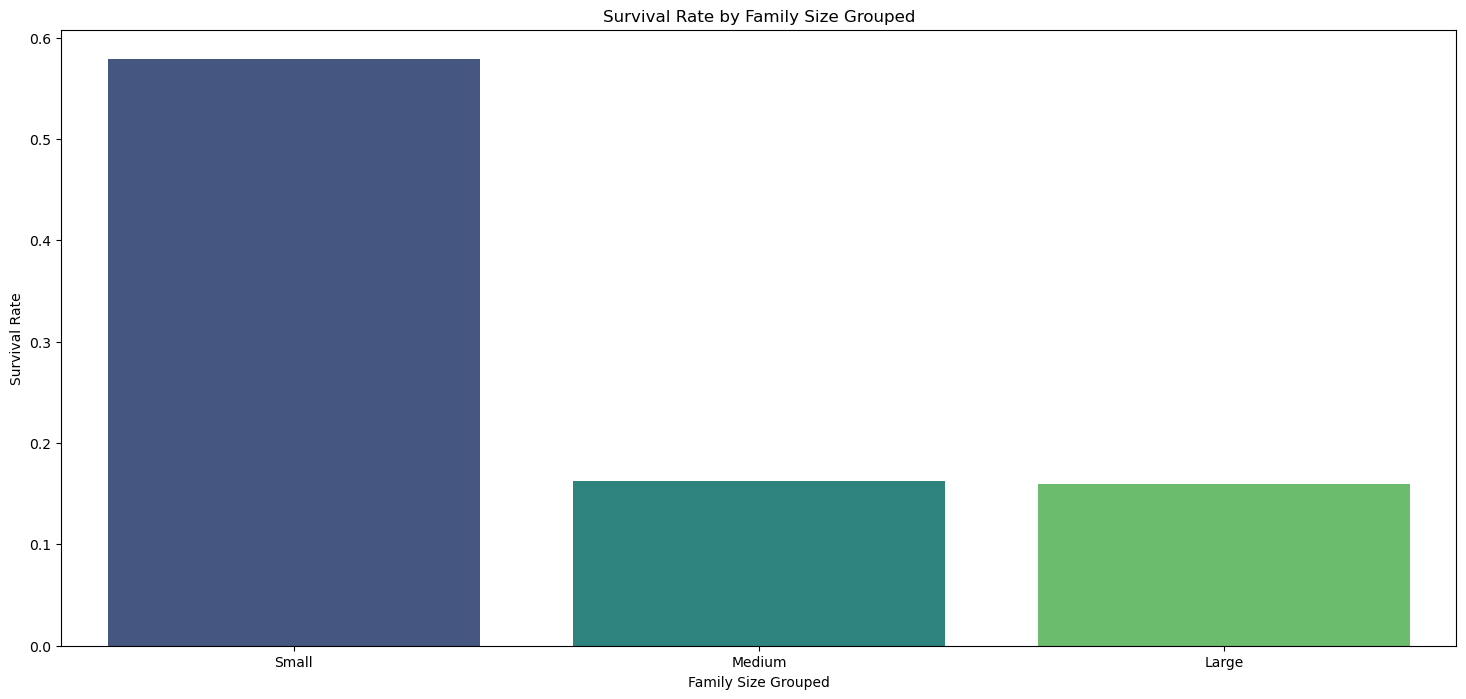

In [24]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Family_Size_Grouped', y='Survived', data=family_grouped_survival, order=['Small', 'Medium', 'Large'], palette="viridis")
plt.title('Survival Rate by Family Size Grouped')
plt.xlabel('Family Size Grouped')
plt.ylabel('Survival Rate')
plt.show()

**7. Survival Rate by Embarked**

In [25]:
embarked_survival = train_df.groupby(['Embarked'], as_index=False)['Survived'].mean()
embarked_survival

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


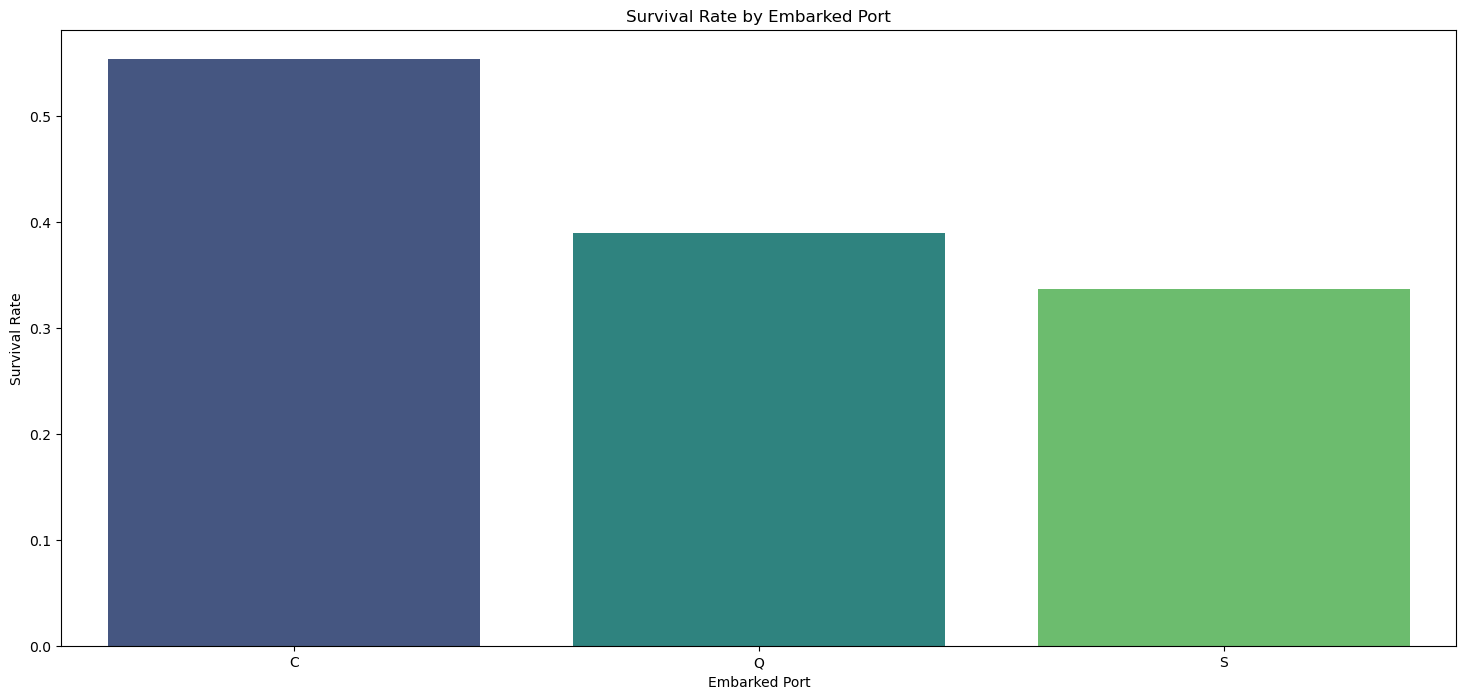

In [26]:
plt.figure(figsize=(18, 8))
sns.barplot(x='Embarked', y='Survived', data=embarked_survival, palette="viridis")
plt.title('Survival Rate by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Survival Rate')
plt.show()

**8. Survival Rate by Age Groups**

In [27]:
# Define bins and labels for numeric and categorical age groupings
age_bins_numeric = [0, 10, 20, 30, 40, 50, 60, 70, 100]  # Include 100 as the upper bound
age_labels_numeric = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70+']  # Label 70+ for the last bin

age_bins_categorical = [0, 12, 18, 35, 60, 100]  # Universal categories
age_labels_categorical = ['Child', 'Teen', 'Adult', 'Middle_Age', 'Senior']

# Apply numeric and categorical age groupings to train and test datasets
train_df['Age_Group_Bin'] = pd.cut(train_df['Age'], bins=age_bins_numeric, labels=age_labels_numeric, right=False)
test_df['Age_Group_Bin'] = pd.cut(test_df['Age'], bins=age_bins_numeric, labels=age_labels_numeric, right=False)

train_df['Age_Group_Cat'] = pd.cut(train_df['Age'], bins=age_bins_categorical, labels=age_labels_categorical, right=False)
test_df['Age_Group_Cat'] = pd.cut(test_df['Age'], bins=age_bins_categorical, labels=age_labels_categorical, right=False)


In [28]:
age_cut_survival = train_df.groupby(['Age_Group_Bin'], as_index=False)['Survived'].mean()
age_cut_survival

,Age_Group_Bin,Survived
0,0-10,0.612903
1,10-20,0.401961
2,20-30,0.350000
3,30-40,0.437126
4,40-50,0.382022
5,50-60,0.416667
6,60-70,0.315789
7,70+,0.142857


In [29]:
age_cut_survival = train_df.groupby(['Age_Group_Cat'], as_index=False)['Survived'].mean()
age_cut_survival

,Age_Group_Cat,Survived
0,Child,0.573529
1,Teen,0.488889
2,Adult,0.368852
3,Middle_Age,0.416268
4,Senior,0.269231


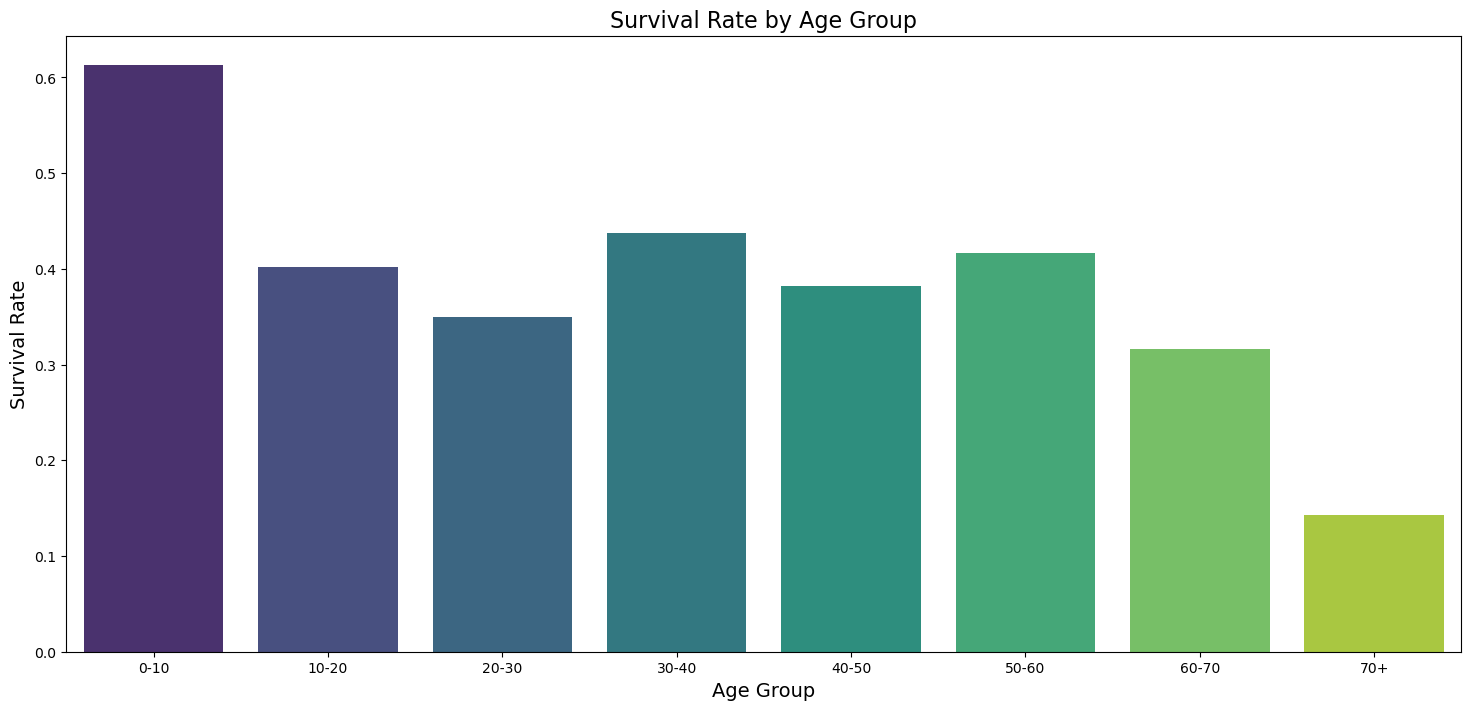

In [30]:
# Calculate survival rate by age group
age_group_survival = train_df.groupby('Age_Group_Bin')['Survived'].agg(np.mean).reset_index()
# Visualize survival rate by age group
plt.figure(figsize=(18, 8))
sns.barplot(data=age_group_survival, x='Age_Group_Bin', y='Survived', palette="viridis")
plt.title('Survival Rate by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Survival Rate', fontsize=14)
plt.show()

In [31]:
# Calculate survival rates by Age Group and Sex
age_sex_survival_rates = train_df.groupby(['Age_Group_Bin', 'Sex'])['Survived'].mean().reset_index()
age_sex_survival_rates.rename(columns={'Survived': 'Survival Rate'}, inplace=True)
age_sex_survival_rates

,Age_Group_Bin,Sex,Survival Rate
0,0-10,female,0.633333
1,0-10,male,0.593750
2,10-20,female,0.755556
3,10-20,male,0.122807
4,20-30,female,0.722222
5,20-30,male,0.168919
6,30-40,female,0.833333
7,30-40,male,0.214953
8,40-50,female,0.687500
9,40-50,male,0.210526


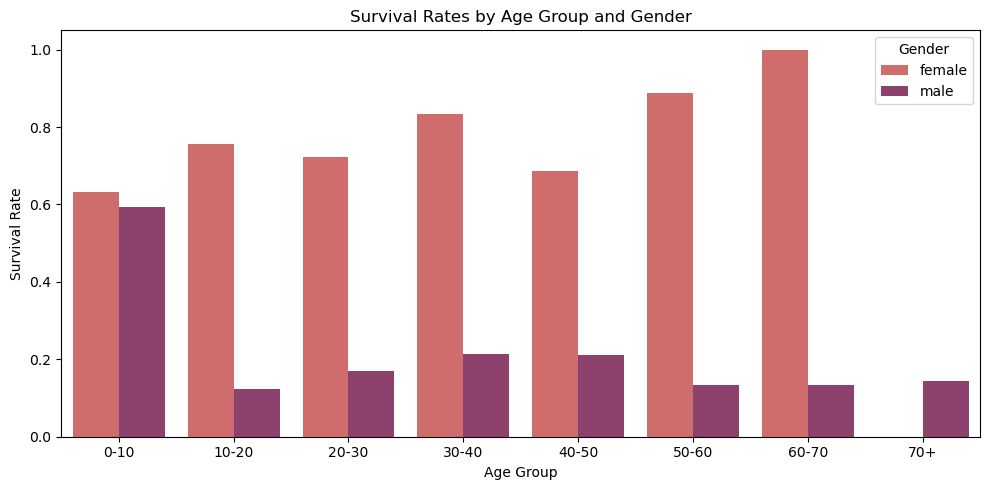

In [32]:
# Visualize the survival rates
plt.figure(figsize=(10, 5))
sns.barplot(x='Age_Group_Bin', y='Survival Rate', palette="flare", hue='Sex', data=age_sex_survival_rates, ci=None)
plt.title('Survival Rates by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate')
plt.legend(title='Gender', loc='upper right')
plt.tight_layout()
plt.show()

In [33]:
# Calculate survival rates by Age_Group_Bin and Pclass
age_pclass_survival_rates_bin = train_df.groupby(['Age_Group_Bin', 'Pclass'])['Survived'].mean().reset_index()
age_pclass_survival_rates_bin.rename(columns={'Survived': 'Survival Rate'}, inplace=True)
age_pclass_survival_rates_bin = age_pclass_survival_rates_bin.sort_values(by='Survival Rate', ascending=False)
age_pclass_survival_rates_bin.head(10)

,Age_Group_Bin,Pclass,Survival Rate
1,0-10,2,1.000000
3,10-20,1,0.833333
9,30-40,1,0.780000
6,20-30,1,0.705882
0,0-10,1,0.666667
12,40-50,1,0.594595
15,50-60,1,0.555556
13,40-50,2,0.555556
4,10-20,2,0.500000
2,0-10,3,0.452381


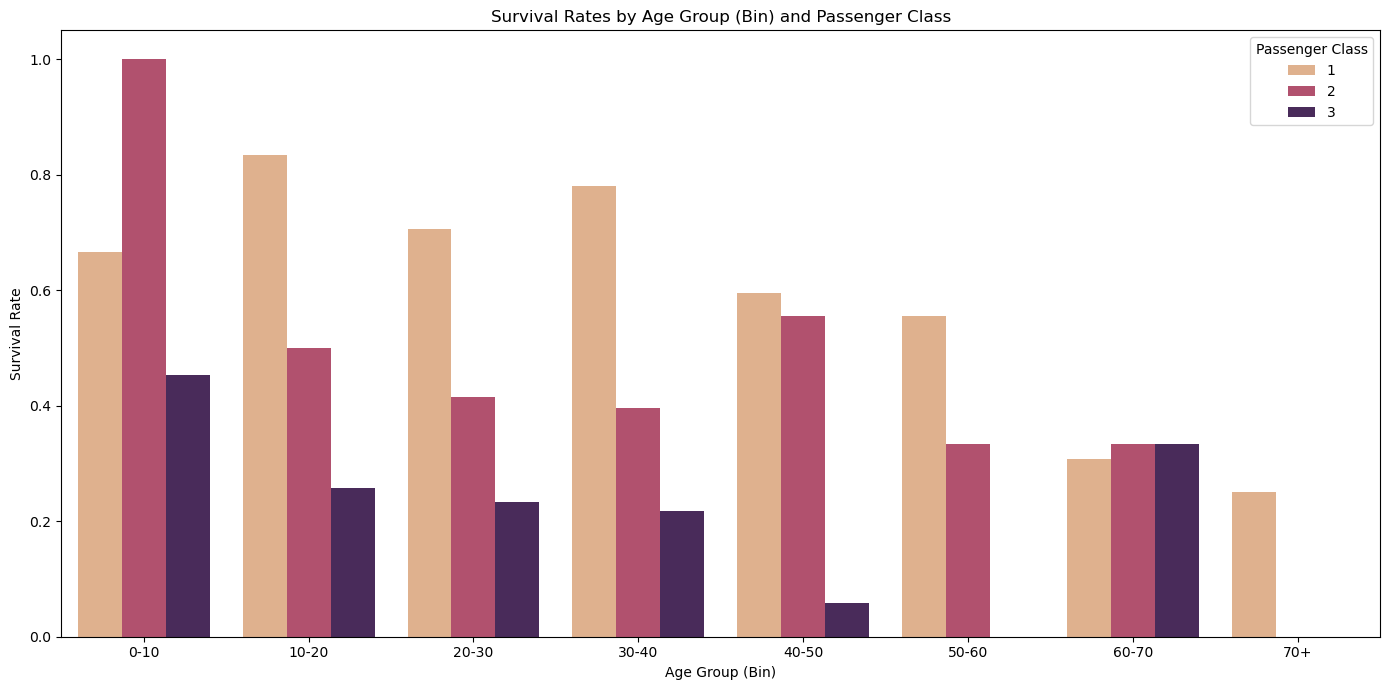

In [34]:
# Visualize survival rates for Age_Group_Bin and Pclass
plt.figure(figsize=(14, 7))
sns.barplot(x='Age_Group_Bin', y='Survival Rate', hue='Pclass', data=age_pclass_survival_rates_bin, ci=None, palette='flare')
plt.title('Survival Rates by Age Group (Bin) and Passenger Class')
plt.xlabel('Age Group (Bin)')
plt.ylabel('Survival Rate')
plt.legend(title='Passenger Class', loc='upper right')
plt.tight_layout()
plt.show()

In [35]:
age_pclass_survival_rates_cat = train_df.groupby(['Age_Group_Cat', 'Pclass'])['Survived'].mean().reset_index()
age_pclass_survival_rates_cat.rename(columns={'Survived': 'Survival Rate'}, inplace=True)
age_pclass_survival_rates_cat = age_pclass_survival_rates_cat.sort_values(by='Survival Rate', ascending=False)
age_pclass_survival_rates_cat.head(10)

,Age_Group_Cat,Pclass,Survival Rate
1,Child,2,1.000000
3,Teen,1,1.000000
0,Child,1,0.750000
6,Adult,1,0.721311
4,Teen,2,0.666667
9,Middle_Age,1,0.645833
7,Adult,2,0.432990
2,Child,3,0.404255
10,Middle_Age,2,0.387755
5,Teen,3,0.322581


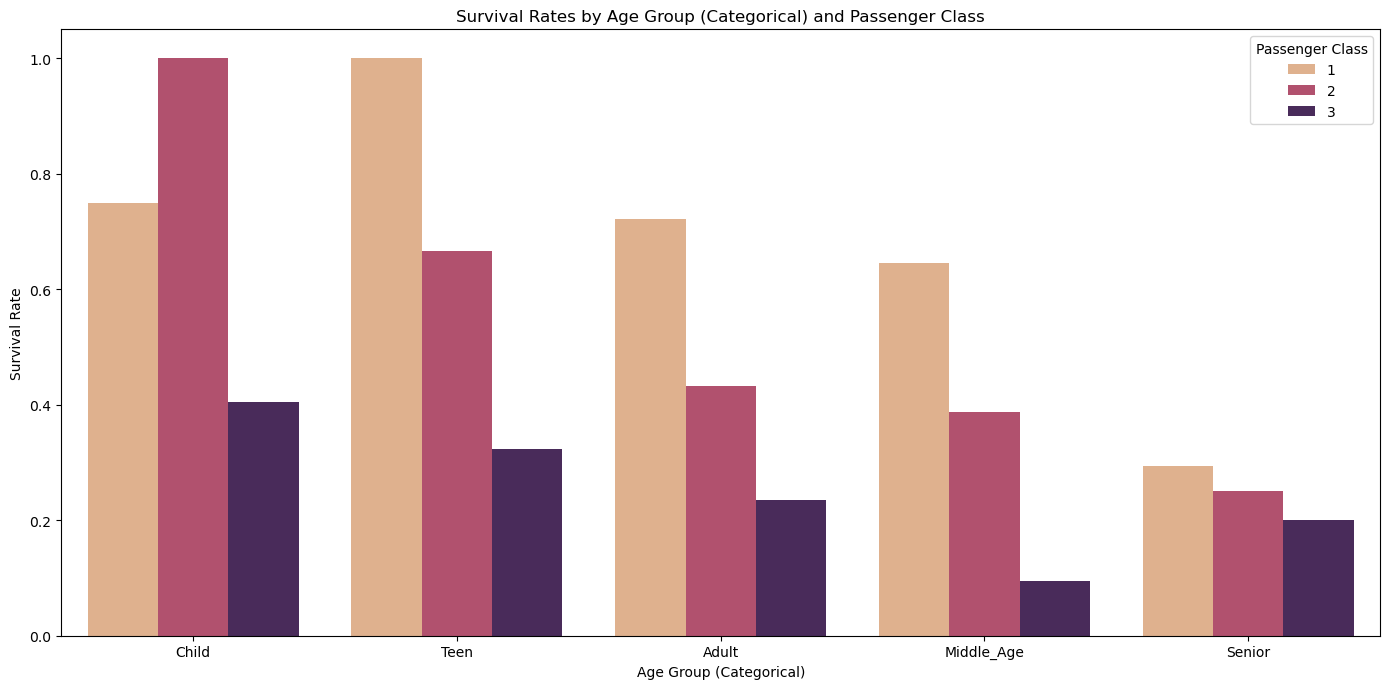

In [36]:
# Visualize survival rates for Age_Group_Cat and Pclass
plt.figure(figsize=(14, 7))
sns.barplot(x='Age_Group_Cat', y='Survival Rate', hue='Pclass', data=age_pclass_survival_rates_cat, ci=None, palette='flare')
plt.title('Survival Rates by Age Group (Categorical) and Passenger Class')
plt.xlabel('Age Group (Categorical)')
plt.ylabel('Survival Rate')
plt.legend(title='Passenger Class', loc='upper right')
plt.tight_layout()
plt.show()

**9. Survival Rate by Fare Groups**

In [37]:
# Define a function to bin Fare values
def bin_fare(fare):
    if fare <= 7.854:
        return 0
    elif fare <= 10.5:
        return 1
    elif fare <= 21.679:
        return 2
    elif fare <= 39.688:
        return 3
    elif fare <= 512.329:
        return 4
    else:
        return 5

# Apply the function to both train and test datasets
train_df['Fare_Range'] = train_df['Fare'].apply(bin_fare)
test_df['Fare_Range'] = test_df['Fare'].apply(bin_fare)

In [38]:
# Check the survival rates for the binned Fare values
fare_survival_rates = train_df.groupby('Fare_Range')['Survived'].mean().reset_index()
fare_survival_rates.rename(columns={'Fare_Range': 'Fare Bin', 'Survived': 'Survival Rate'}, inplace=True)
fare_survival_rates

,Fare Bin,Survival Rate
0,0,0.216867
1,1,0.203046
2,2,0.426901
3,3,0.441989
4,4,0.635838
5,5,1.000000


In [39]:
# Group by Fare_Range and calculate the mean survival rate
fare_survival_rates = train_df.groupby('Fare_Range', as_index=False)['Survived'].mean()
fare_survival_rates.rename(columns={'Fare_Range': 'Fare Group', 'Survived': 'Survival Rate'}, inplace=True)
fare_survival_rates = fare_survival_rates.sort_values(by='Fare Group', ascending=False)
fare_survival_rates

,Fare Group,Survival Rate
5,5,1.000000
4,4,0.635838
3,3,0.441989
2,2,0.426901
1,1,0.203046
0,0,0.216867


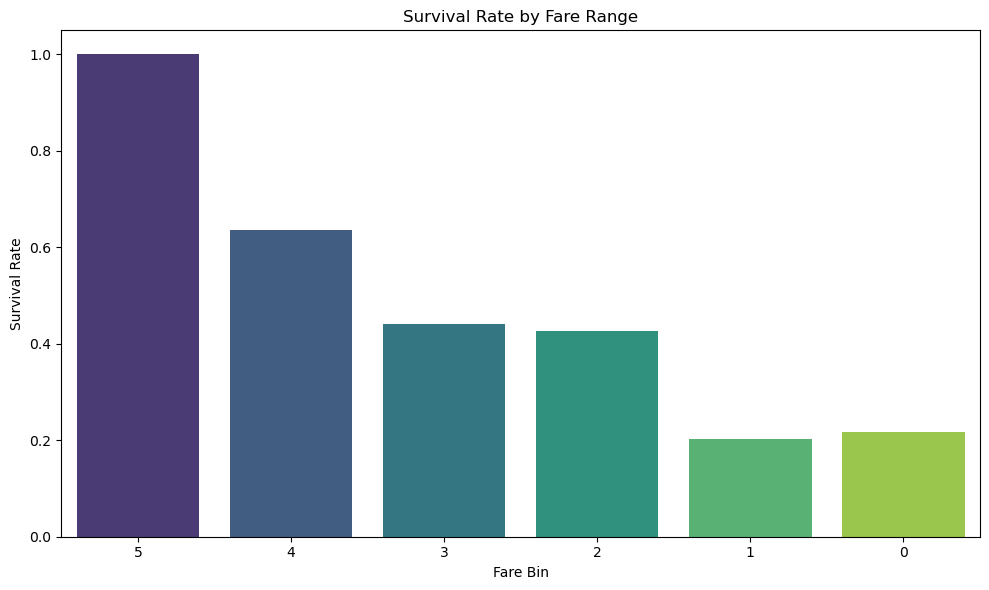

In [40]:
# Ensure 'Fare Group' is a categorical variable with the correct order
fare_survival_rates['Fare Group'] = pd.Categorical(
    fare_survival_rates['Fare Group'],
    categories=fare_survival_rates['Fare Group'].unique(),
    ordered=True
)

# Sort the DataFrame by 'Fare Group' order
fare_survival_rates = fare_survival_rates.sort_values(by='Fare Group', ascending=True)

# Visualization using viridis palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Fare Group', y='Survival Rate', data=fare_survival_rates, palette="viridis", ci=None)
plt.title('Survival Rate by Fare Range')
plt.xlabel('Fare Bin')
plt.ylabel('Survival Rate')
plt.yticks()
plt.tight_layout()
plt.show()

**10. Survival Rate by Title**

In [41]:
# Extract titles from names
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [42]:
title_survival = train_df.groupby(['Title'], as_index=False)['Survived'].mean()
title_survival

,Title,Survived
0,Capt,0.000000
1,Col,0.500000
2,Countess,1.000000
3,Don,0.000000
4,Dr,0.428571
5,Jonkheer,0.000000
6,Lady,1.000000
7,Major,0.500000
8,Master,0.575000
9,Miss,0.697802


In [43]:
# Define simplified mapping for title categories
title_category_map = {
    **dict.fromkeys(['Capt', 'Col', 'Major'], 'Military'),
    **dict.fromkeys(['Jonkheer', 'the Countess', 'Don', 'Lady', 'Sir', 'Dona'], 'Noble'),
    **dict.fromkeys(['Dr', 'Rev'], 'Professional'),
    **dict.fromkeys(['Mlle', 'Ms', 'Mme', 'Mr', 'Mrs', 'Miss'], 'Commoner'),
    **dict.fromkeys(['Master'], 'Master')
}

# Apply the mapping to train and test datasets
train_df['Title'] = train_df['Title'].replace(title_category_map)
test_df['Title'] = test_df['Title'].replace(title_category_map)

In [44]:
# Check survival rates by title
title_survival = train_df.groupby(['Title'], as_index=False)['Survived'].mean()
title_survival

,Title,Survived
0,Commoner,0.375604
1,Countess,1.000000
2,Master,0.575000
3,Military,0.400000
4,Noble,0.500000
5,Professional,0.230769


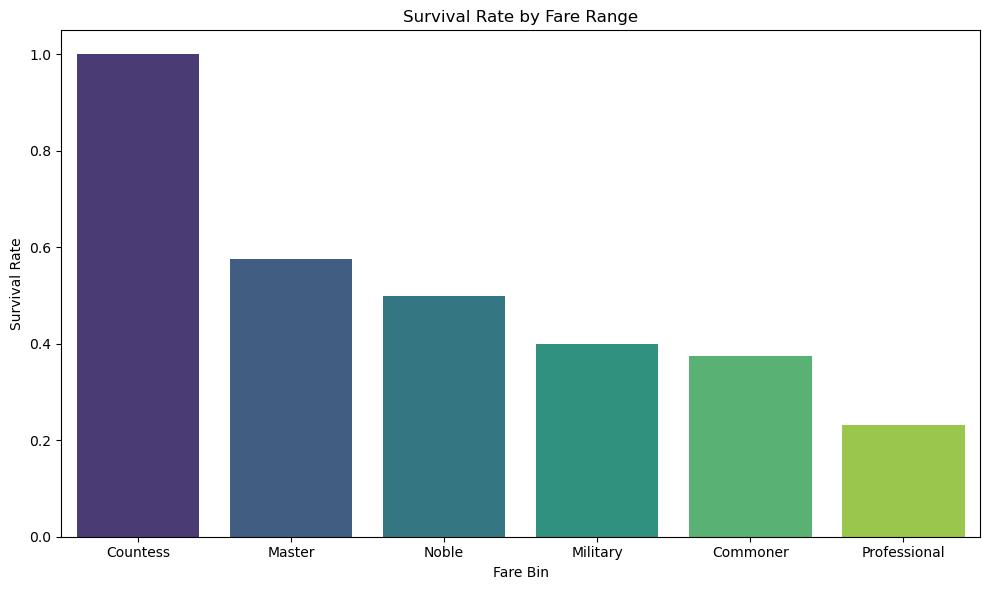

In [45]:
title_survival = title_survival.sort_values(by='Survived', ascending=False)

# Visualization using viridis palette
plt.figure(figsize=(10, 6))
sns.barplot(x='Title', y='Survived', data=title_survival, palette="viridis", ci=None)
plt.title('Survival Rate by Fare Range')
plt.xlabel('Fare Bin')
plt.ylabel('Survival Rate')
plt.yticks()
plt.tight_layout()
plt.show()

### **Preprocessing the Dataset**

**Handling Missing Values**

In [46]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace=True)
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

In [47]:
# Define columns for encoding
ordinal_columns = ['Family_Size_Grouped', 'Age_Group_Bin', 'Age_Group_Cat', 'Fare_Range']
onehot_columns = ['Sex', 'Title', 'Pclass']

In [48]:
SI = SimpleImputer(strategy='most_frequent')

In [49]:
# Ordinal Encoder Pipeline
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
# Define Preprocessing Pipeline
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Fare_Per_Person', 'Fare_Log']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Sex', 'Embarked', 'Title', 'Age_Bin', 'Gender*Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# One-Hot Encoder Pipeline
onehot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocessor with corrected columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_pipeline, ordinal_columns),
    ('onehot', onehot_pipeline, onehot_columns),
    ('passthrough', 'passthrough', ['IsAlone', 'Age', 'Fare', 'Family_Size'])
])

**Splitting Data**

In [50]:
# Separate features and target variable
X = train_df.drop(['Survived', 'SibSp', 'Parch', 'Ticket', 'Name', 'Cabin', 'Embarked'], axis=1)
y = train_df['Survived']
X_test = test_df.drop(['SibSp', 'Parch', 'Ticket', 'Name', 'Cabin', 'Embarked'], axis=1)

# Split the training data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### **Model Building and Hyperparameter Tuning**

**Random Forest**

In [51]:
rf_model = RandomForestClassifier()

In [52]:
# Define Random Forest parameters
rf_params = {
    'n_estimators': [150, 200, 300],
    'min_samples_split': [5, 10],
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

In [53]:
# Perform GridSearchCV for Random Forest
rf_grid = GridSearchCV(estimator=rf_model, param_grid=rf_params, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('grid_search', rf_grid)])
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strate...
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('grid_search',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=RandomForestClassifier(),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 15, 20],
                                          'min_samples_split': [5, 10],
                                          'n_estimators': [150, 200, 300]},
                              scoring='accuracy'))])

In [54]:
# Display best parameters and score
print("Random Forest Best Params:", rf_grid.best_params_)
print("Random Forest Best Score:", rf_grid.best_score_)

Random Forest Best Params: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 300}
Random Forest Best Score: 0.8301290259036737


In [55]:
# Predict on validation set
y_pred_valid_rf = rf_pipeline.predict(X_valid)

In [56]:
# Calculate validation accuracy
valid_accuracy_rf = accuracy_score(y_valid, y_pred_valid_rf)

# Print evaluation results
print(f"Validation Accuracy: {valid_accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_rf))

Validation Accuracy: 0.8212

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



**Decision Tree**

In [57]:
dtc = DecisionTreeClassifier()

In [58]:
# Define Decision Tree parameters
dt_params = {
    'min_samples_split': [5, 10],
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}

In [59]:
# Perform GridSearchCV for Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(estimator=dt_model, param_grid=dt_params, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('grid_search', dt_grid)])
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strate...
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('grid_search',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=DecisionTreeClassifier(random_state=42),
                              param_grid={'criterion': ['gini', 'entropy'],
                                          'max_depth': [10, 15, 20],
                                          'min_samples_split': [5, 10]},
                              scoring='accuracy'))])

In [60]:
# Display best parameters and score
print("Decision Tree Best Params:", dt_grid.best_params_)
print("Decision Tree Best Score:", dt_grid.best_score_)

Decision Tree Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}
Decision Tree Best Score: 0.8105092091007584


In [61]:
# Predict on validation set
y_pred_valid_dt = dt_pipeline.predict(X_valid)

In [62]:
# Calculate validation accuracy
valid_accuracy_dt = accuracy_score(y_valid, y_pred_valid_dt)

# Print evaluation results
print("### Decision Tree Model Evaluation ###")
print(f"Validation Accuracy: {valid_accuracy_dt:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_dt))

### Decision Tree Model Evaluation ###
Validation Accuracy: 0.8045

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



**K-Nearest Neighbors**

In [63]:
knn = KNeighborsClassifier()

In [64]:
# Define KNN parameters
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree']
}

In [65]:
# Perform GridSearchCV for KNN
knn_model = KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn_model, param_grid=knn_params, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('grid_search', knn_grid)])
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strate...
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('grid_search',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=KNeighborsClassifier(),
                              param_grid={'algorithm': ['auto', 'ball_tree'],
                                          'n_neighbors': [3, 5, 7],
                                          'weights': ['uniform', 'distance']},
                              scoring='accuracy'))])

In [66]:
# Display best parameters and score
print("KNN Best Params:", knn_grid.best_params_)
print("KNN Best Score:", knn_grid.best_score_)

KNN Best Params: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
KNN Best Score: 0.7445385600315177


In [67]:
# Predict on validation set
y_pred_valid_knn = knn_pipeline.predict(X_valid)

In [68]:
valid_accuracy_knn = accuracy_score(y_valid, y_pred_valid_knn)

print("### KNN Model Evaluation ###")
print(f"Validation Accuracy: {valid_accuracy_knn:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_knn))

### KNN Model Evaluation ###
Validation Accuracy: 0.7207

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77       110
           1       0.64      0.62      0.63        69

    accuracy                           0.72       179
   macro avg       0.70      0.70      0.70       179
weighted avg       0.72      0.72      0.72       179



**Support Vector Classifier (SVC)**
- Model Definition and Hyperparameter Tuning

In [69]:
svc = SVC(probability=True)

In [70]:
param_grid = {
    'C': [100, 10, 1.0, 0.1, 0.001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

In [71]:
# Preprocessor with corrected columns
preprocessor = ColumnTransformer(transformers=[
    ('ordinal', ordinal_pipeline, ordinal_columns),
    ('onehot', onehot_pipeline, onehot_columns),
    ('passthrough', 'passthrough', ['IsAlone', 'Age', 'Fare', 'Family_Size'])
])

In [72]:
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinalsvc = make_pipeline(preprocessor, CV_svc)
pipefinalsvc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=SVC(probability=True),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']}))])

In [73]:
# Best parameters and score
print("SVC Best Params:", CV_svc.best_params_)
print("SVC Best Score:", CV_svc.best_score_)

SVC Best Params: {'C': 1.0, 'kernel': 'linear'}
SVC Best Score: 0.8272727272727274


**Model Evaluation**

In [74]:
y_pred_valid_svc = pipefinalsvc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid, y_pred_valid_svc)

In [75]:
print("\n### SVC Evaluation ###")
print(f"Validation Accuracy: {svc_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_svc))


### SVC Evaluation ###
Validation Accuracy: 0.8268

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.80      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179



**Logistic Regression**
- Model Definition and Hyperparameter Tuning

In [76]:
lr = LogisticRegression()

In [77]:
param_grid = {'C': [100, 10, 1.0, 0.1, 0.001]}
CV_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinallr = make_pipeline(preprocessor, CV_lr)
pipefinallr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s...t_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=LogisticRegression(),
                              param_grid={'C': [100, 10, 1.0, 0.1, 0.001]}))])

In [78]:
print("Logistic Regression Best Params:", CV_lr.best_params_)
print("Logistic Regression Best Score:", CV_lr.best_score_)

Logistic Regression Best Params: {'C': 10}
Logistic Regression Best Score: 0.8174726681768936


**Model Evaluation**

In [79]:
y_pred_valid_lr = pipefinallr.predict(X_valid)
lr_accuracy = accuracy_score(y_valid, y_pred_valid_lr)

In [80]:
print("\n### Logistic Regression Evaluation ###")
print(f"Validation Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_lr))


### Logistic Regression Evaluation ###
Validation Accuracy: 0.8436

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88       110
           1       0.83      0.75      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



**Gaussian Naive Bayes (GNB)**
- Model Definition and Hyperparameter Tuning

In [81]:
gnb = GaussianNB()

In [82]:
param_grid = {'var_smoothing': [1e-8, 1e-9, 1e-10]}
CV_gnb = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinalgnb = make_pipeline(preprocessor, CV_gnb)
pipefinalgnb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s..._frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GaussianNB(),
                              param_grid={'var_smoothing': [1e-08, 1e-09,
                                                            1e-10]}))])

In [83]:
print("GNB Best Params:", CV_gnb.best_params_)
print("GNB Best Score:", CV_gnb.best_score_)

GNB Best Params: {'var_smoothing': 1e-08}
GNB Best Score: 0.7767162415049739


**Model Evaluation**

In [84]:
y_pred_valid_gnb = pipefinalgnb.predict(X_valid)
gnb_accuracy = accuracy_score(y_valid, y_pred_valid_gnb)

In [85]:
print("\n### Gaussian Naive Bayes Evaluation ###")
print(f"Validation Accuracy: {gnb_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_gnb))


### Gaussian Naive Bayes Evaluation ###
Validation Accuracy: 0.7765

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81       110
           1       0.70      0.74      0.72        69

    accuracy                           0.78       179
   macro avg       0.76      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



**XGBoost Classifier**
- Model Definition and Hyperparameter Tuning

In [86]:
xg = XGBClassifier()

In [87]:
param_grid = {'booster': ['gbtree', 'gblinear', 'dart']}
CV_xg = GridSearchCV(estimator=xg, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinalxg = make_pipeline(preprocessor, CV_xg)
pipefinalxg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s...
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              param_grid={'booster': ['gbtree', 'gblinear',
                                                      'dart']}))])

In [88]:
print("XGBoost Best Params:", CV_xg.best_params_)
print("XGBoost Best Score:", CV_xg.best_score_)

XGBoost Best Params: {'booster': 'gblinear'}
XGBoost Best Score: 0.8132473160642176


**Model Evaluation**

In [89]:
y_pred_valid_xg = pipefinalxg.predict(X_valid)
xg_accuracy = accuracy_score(y_valid, y_pred_valid_xg)

In [90]:
print("\n### XGBoost Evaluation ###")
print(f"Validation Accuracy: {xg_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_xg))


### XGBoost Evaluation ###
Validation Accuracy: 0.8380

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



**AdaBoost Classifier**
- Model Definition and Hyperparameter Tuning

In [91]:
abc = AdaBoostClassifier()

In [92]:
param_grid = {
    'n_estimators': [5, 10, 25],
    'learning_rate': [0.97, 0.98, 0.99]
}

In [93]:
CV_abc = GridSearchCV(estimator=abc, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinalabc = make_pipeline(preprocessor, CV_abc)
pipefinalabc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=AdaBoostClassifier(),
                              param_grid={'learning_rate': [0.97, 0.98, 0.99],
                                          'n_estimators': [5, 10, 25]}))])

In [94]:
print("AdaBoost Best Params:", CV_abc.best_params_)
print("AdaBoost Best Score:", CV_abc.best_score_)

AdaBoost Best Params: {'learning_rate': 0.99, 'n_estimators': 10}
AdaBoost Best Score: 0.8189500640204865


**Model Evaluation**

In [95]:
y_pred_valid_abc = pipefinalabc.predict(X_valid)
abc_accuracy = accuracy_score(y_valid, y_pred_valid_abc)

In [96]:
print("\n### AdaBoost Evaluation ###")
print(f"Validation Accuracy: {abc_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_abc))


### AdaBoost Evaluation ###
Validation Accuracy: 0.8045

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       110
           1       0.75      0.74      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



**Gradient Boosting Classifier (GBC)**
- Model Definition and Hyperparameter Tuning

In [97]:
GBC = GradientBoostingClassifier()

In [98]:
param_grid = {
    'n_estimators': [300, 400],
    'learning_rate': [0.1, 0.3],
    'max_depth': [8, 10],
    'min_samples_leaf': [50, 100],
    'max_features': [0.1, 0.3]
}

In [99]:
CV_gbc = GridSearchCV(estimator=GBC, param_grid=param_grid, cv=StratifiedKFold(n_splits=5))
pipefinalgbc = make_pipeline(preprocessor, CV_gbc)
pipefinalgbc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Family_Size_Grouped',
                                                   'Age_Group_Bin',
                                                   'Age_Group_Cat',
                                                   'Fare_Range']),
                                                 ('onehot',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(s...
                                                  ['Sex', 'Title', 'Pclass']),
                                                 ('passthrough', 'passthrough',
                                                  ['IsAlone', 'Age', 'Fare',
                                                   'Family_Size'])])),
                ('gridsearchcv',
                 GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                              estimator=GradientBoostingClassifier(),
                              param_grid={'learning_rate': [0.1, 0.3],
                                          'max_depth': [8, 10],
                                          'max_features': [0.1, 0.3],
                                          'min_samples_leaf': [50, 100],
                                          'n_estimators': [300, 400]}))])

In [100]:
print("Gradient Boosting Best Params:", CV_gbc.best_params_)
print("Gradient Boosting Best Score:", CV_gbc.best_score_)

Gradient Boosting Best Params: {'learning_rate': 0.3, 'max_depth': 10, 'max_features': 0.1, 'min_samples_leaf': 100, 'n_estimators': 400}
Gradient Boosting Best Score: 0.8315079286910272


**Model Evaluation**

In [101]:
y_pred_valid_gbc = pipefinalgbc.predict(X_valid)
gbc_accuracy = accuracy_score(y_valid, y_pred_valid_gbc)

In [102]:
print("\n### Gradient Boosting Evaluation ###")
print(f"Validation Accuracy: {gbc_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_valid, y_pred_valid_gbc))


### Gradient Boosting Evaluation ###
Validation Accuracy: 0.8212

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179




## **Key Insights**

### **1. Survival by Passenger Class**
- **First-class passengers** had the highest survival rate (**62.96%**), while **Third-class passengers** fared the worst (**24.24%**).  
- **Visual:**  
  - Bar chart: Survival rates by class.
  - Pie chart: Proportion of passengers in each class.


### **2. Survival by Gender**
- **Females:** Survival rate of **74.20%**.  
- **Males:** Survival rate of **18.89%**.  
- **Visual:**  
  - Stacked bar chart: Gender-specific survival rates by class.


### **3. Family Dynamics**
- **Small families (2–4 members):** Highest survival rates (**72.41%**).  
- **Solo travelers:** Lower survival rate (**30.3%**).  
- **Large families (5+ members):** Extremely low survival rates (~**13.64%**).  
- **Visual:**  
  - Line plot: Survival rates by family size.  


### **4. Age and Survival**
- **Children (0–10 years):** Highest survival (**61.29%**).  
- **Seniors (70+ years):** Lowest survival (**14.29%**).  
- **Visual:**  
  - Heatmap: Age group survival by class.  


### **5. Socio-Economic Influence**
- **Fare:** Higher fares strongly correlated with survival (**100% for top fare bins**).  
- **Visual:**  
  - Scatter plot: Survival vs. fare.  


### **6. Embarkation Port**
- **Cherbourg (C):** Highest survival rate (**55.36%**).  
- **Southampton (S):** Lowest survival (**33.7%**).  
- **Visual:**  
  - Bar chart: Survival rates by embarkation port.  

### **Model Performance Summary**:
1. **Logistic Regression:**
   - **Best Score:** **0.817**  
   - **Validation Accuracy:** **0.8436**  
   - **Strengths:** Best overall validation accuracy, with a balanced classification report. Recommended for explainability and linear relationships.

2. **SVC:**
   - **Best Score:** **0.827**  
   - **Validation Accuracy:** **0.8268**  
   - **Strengths:** Strong performance in accuracy and balanced metrics. Suitable for datasets with linear separability.

3. **XGBoost:**
   - **Best Score:** **0.813**  
   - **Validation Accuracy:** **0.8380**  
   - **Strengths:** Robust handling of complex patterns. Comparable to Logistic Regression in accuracy and balanced metrics.

4. **Random Forest:**
   - **Best Score:** **0.830**  
   - **Validation Accuracy:** **0.7989**  
   - **Strengths:** High interpretability and balanced performance, with optimal hyperparameters (e.g., **max_depth=10**, **n_estimators=150**).

5. **Gradient Boosting:**
   - **Best Score:** **0.830**  
   - **Validation Accuracy:** **0.8156**  
   - **Strengths:** Strong handling of non-linear patterns and higher precision for positive cases.

6. **AdaBoost:**
   - **Best Score:** **0.819**  
   - **Validation Accuracy:** **0.8045**  
   - **Strengths:** Moderate performance with lower complexity than Gradient Boosting.

7. **Decision Tree:**
   - **Best Score:** **0.811**  
   - **Validation Accuracy:** **0.8045**  
   - **Strengths:** Simple model, fast training, but slightly lower overall metrics.

8. **Gaussian Naive Bayes:**
   - **Best Score:** **0.777**  
   - **Validation Accuracy:** **0.7765**  
   - **Strengths:** Efficient but suffers in handling complex relationships.

9. **KNN:**
   - **Best Score:** **0.745**  
   - **Validation Accuracy:** **0.7207**  
   - **Strengths:** Simple, but sensitive to class imbalance and less effective on this dataset.

### **Key Metrics**:

- **Highest Validation Accuracy:** **Logistic Regression (0.8436)**  
- **Highest Recall for Class 1 (Survivors):** XGBoost (**0.75**)  
- **Best Balance of Precision and Recall (F1-Score):** Logistic Regression (**0.79 for Class 1**) 